## Importing Required Library

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer

## Reading Data Files

In [142]:
df = pd.read_csv('house.csv',usecols=['FullBath','BedroomAbvGr','TotRmsAbvGrd','GarageYrBlt','GarageCars','GarageArea','SalePrice','OverallQual','1stFlrSF','GrLivArea','BsmtFullBath','YearBuilt','YearRemodAdd','BsmtFinSF1','TotalBsmtSF'])

df.dropna(inplace=True)
df['GarageYrBlt']= df['GarageYrBlt'].astype('int64')

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1379 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   OverallQual   1379 non-null   int64
 1   YearBuilt     1379 non-null   int64
 2   YearRemodAdd  1379 non-null   int64
 3   BsmtFinSF1    1379 non-null   int64
 4   TotalBsmtSF   1379 non-null   int64
 5   1stFlrSF      1379 non-null   int64
 6   GrLivArea     1379 non-null   int64
 7   BsmtFullBath  1379 non-null   int64
 8   FullBath      1379 non-null   int64
 9   BedroomAbvGr  1379 non-null   int64
 10  TotRmsAbvGrd  1379 non-null   int64
 11  GarageYrBlt   1379 non-null   int64
 12  GarageCars    1379 non-null   int64
 13  GarageArea    1379 non-null   int64
 14  SalePrice     1379 non-null   int64
dtypes: int64(15)
memory usage: 172.4 KB


## Exploring Data

In [144]:
from pandas_profiling import ProfileReport

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

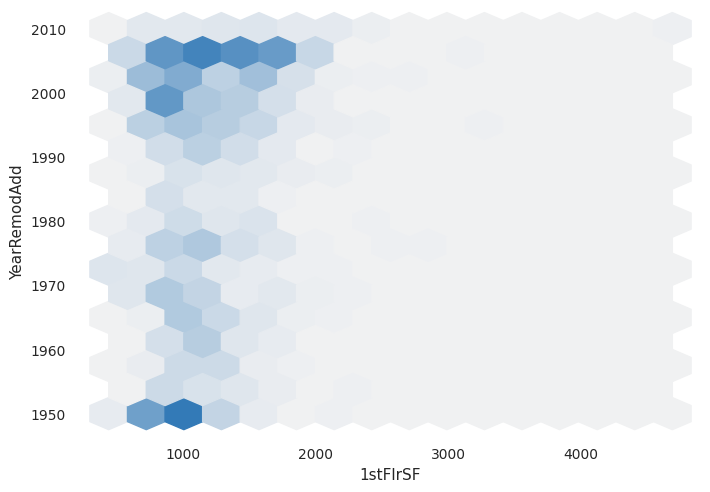

In [145]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

## Sperating Variable (Input & Target) due to Data Leakage

In [146]:
X = df.drop(columns='SalePrice')
y = df['SalePrice']

In [147]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=None)

In [148]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

tnf1 = ColumnTransformer([
        ('impute',SimpleImputer(strategy='median'),slice(0-13))
], 
    remainder='passthrough')


In [149]:
tnf2 = ColumnTransformer([
        ('trans',MinMaxScaler(),slice(0-13))],
    remainder='passthrough'
)

In [150]:
tnf3 = Ridge(alpha=0.2,max_iter=100,solver='auto')

In [151]:
pipe = Pipeline([
    ('tnf1',tnf1),
    ('tnf2',tnf2),
    ('tnf3',tnf3)
])

In [152]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('tnf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute',
                                                  SimpleImputer(strategy='median'),
                                                  slice(None, -13, None))])),
                ('tnf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trans', MinMaxScaler(),
                                                  slice(None, -13, None))])),
                ('tnf3', Ridge(alpha=0.2, max_iter=100))])

In [153]:
y_pred = pipe.predict(X_test)

In [154]:
from sklearn.metrics import r2_score 
r2_score(y_test,y_pred)

0.7717392937267074

## Cross Validation

In [155]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipe, X, y, cv=10, scoring='r2').mean()

0.770341792067419

## Hyperparameter Tunning

In [156]:
from sklearn.model_selection import GridSearchCV
Ridge()
params = {
    'tnf3__alpha':[0.1,0.01,0.02,0.2,0.001],
    'tnf3__max_iter':[100,300,200,150,400],
    'tnf3__solver':['auto', 'svd', 'cholesky', 'lsqr']
}

In [157]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=5, scoring='r2',n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tnf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('impute',
                                                                         SimpleImputer(strategy='median'),
                                                                         slice(None, -13, None))])),
                                       ('tnf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('trans',
                                                                         MinMaxScaler(),
                                                                         slice(None, -13, None))])),
                                       ('tnf3',
                                        Ridge(alpha=0.2, max_iter=100))]),
             n_jobs=-1,
             param_grid={'tnf3__alpha': [0.1, 0.01, 0.02, 0.2, 0.001],
                         'tnf3__max_iter': [100, 300, 200, 150, 400],
                         'tnf3__solver': ['auto', 'svd', 'cholesky', 'lsqr']},
             scoring='r2')

In [158]:
grid.best_score_

0.7644708535972615

In [159]:
grid.best_params_

{'tnf3__alpha': 0.001, 'tnf3__max_iter': 100, 'tnf3__solver': 'auto'}

## Exporting Pipline

In [160]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))